In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import funcs.utils as utils
import funcs.plotting as plot
import funcs.amyloid as amyloid

In [2]:
PROCESSED_DIR = "data/processed"

### 1. Load Data
---

In [3]:
# Includes only continuous variables
# Comparison of multiple imputation methods
X = pd.read_csv(os.path.join(PROCESSED_DIR, "AL_for_ccp_02.tsv"), sep='\t', index_col=0).rename(columns=amyloid.ddict_unclean)
X.head()

data_df = pd.read_csv(os.path.join(PROCESSED_DIR, "dataset_processed.tsv"), sep='\t', index_col=0).rename(columns=amyloid.ddict_unclean)

# Fix Dates
data_df = pd.concat([pd.to_datetime(data_df[amyloid.dates][var], format="mixed") for var in amyloid.dates], axis=1, keys=amyloid.dates).join(
    data_df.drop(amyloid.dates, axis=1)  
)

### 2. Imputation
---

* Requires running `02a_imputation.ipynb` for `mice::mice`

Methods included:
* Median imputation
* KNN imputation (K=5)
* MICE imptuation (in R)


In [4]:
from sklearn.impute import KNNImputer

# Median imputation
Xi_median = X.fillna(X.median())

# KNN Imputation
KNN_NEIGHBORS = 5

imputer = KNNImputer(n_neighbors=KNN_NEIGHBORS)

Xi_knn = pd.DataFrame(
    imputer.fit_transform(X), 
    index=X.index, 
    columns=X.columns
)

# MICE imputation
Xi_mice = pd.read_csv("data/imputed/mice_qvars_01.tsv", sep="\t").rename(
    columns={'X24_hr_UTP':'24_hr_UTP'}).rename(columns=amyloid.ddict_unclean)

FileNotFoundError: [Errno 2] No such file or directory: 'data/imputed/mice_v1.tsv'

In [30]:
# Comparison of imputation to mean
Xi_comparison = pd.DataFrame(X.mean(), index=X.columns, columns=['original']).join(
    pd.DataFrame(Xi_median.mean(), index=X.columns, columns=['median_imputed'])).join(
    pd.DataFrame(Xi_knn.mean(), index=X.columns, columns=['knn_imputed'])).join(
    pd.DataFrame(Xi_mice.mean(), index=X.columns, columns=['mice_imputed'])
)

Xi_comparison

,original,median_imputed,knn_imputed,mice_imputed
24-hr UTP,4052.473632,3845.105072,4112.675901,3964.184330
Albumin,3.218430,3.234832,3.233061,3.256322
Alk phos,164.674310,155.423913,168.273367,164.745471
BNP,500.345154,373.042120,508.067102,511.190217
Bone marrow plasma cells (%),9.857912,9.880435,9.684811,9.853714
Calcium,9.181449,9.144611,9.155648,9.204710
Creatinine,1.740653,1.659991,1.760747,1.709601
D-dimer,209.577326,131.360829,206.626118,210.673555
Diastolic BP sitting,75.858159,75.864583,75.817693,75.860054
Factor X,88.135439,88.268569,87.747139,88.150815


In [31]:
err = Xi_comparison.T - Xi_comparison['original']
mse = err.T**2
mse.sum(0)

original              0.000000
median_imputed    69547.487783
knn_imputed        4952.867214
mice_imputed       8391.160834
dtype: float64

In [37]:
Xi_median.rename(columns=amyloid.ddict_clean).to_csv("data/imputed/median_qvars_01.tsv", sep="\t")
Xi_knn.rename(columns=amyloid.ddict_clean).to_csv("data/imputed/knn_qvars_01.tsv", sep="\t")

### 3. Load Conseus Cluster Plus
---

In [146]:
mice_01_ccp = pd.read_csv("data/clustering/mice_qvars_01/item_consensus.tsv", sep='\t')

n_clusters = 4

# Filter by n clusters
mice_01_ccp = mice_01_ccp[mice_01_ccp['k']==n_clusters]
mice_01_ccp = mice_01_ccp.loc[
    mice_01_ccp.groupby('item')['itemConsensus'].idxmax(),
    ['item','cluster','itemConsensus']
]

mice_01_ccp = mice_01_ccp.rename(columns={'item':'Code_ID'}).set_index("Code_ID")


### 3. Principal Components Analysis
---

Can perform this either:
* With imputed data
* With probabalistic PCA (`ppca`)

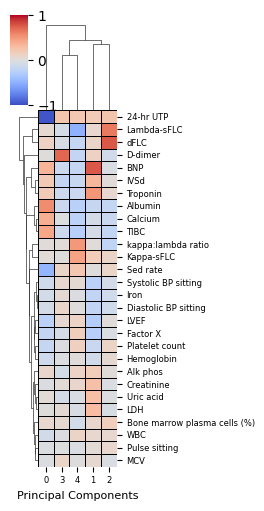

In [97]:
# Using MICE imputed
P_df, pca, pca_vars = utils.get_pcs(Xi_mice.T)

plot.plot_clustermap(
    P_df.join(Xi_mice).corr('spearman').loc[Xi_mice.columns, P_df.columns].sort_values(1),
    figsize=(3.5,5),
    xlabel='Principal Components'
)

In [166]:
data_df.join(mice_01_ccp).rename(columns=amyloid.ddict_clean).to_csv(os.path.join(PROCESSED_DIR,"AL_with_ccp_03.tsv"), sep="\t")

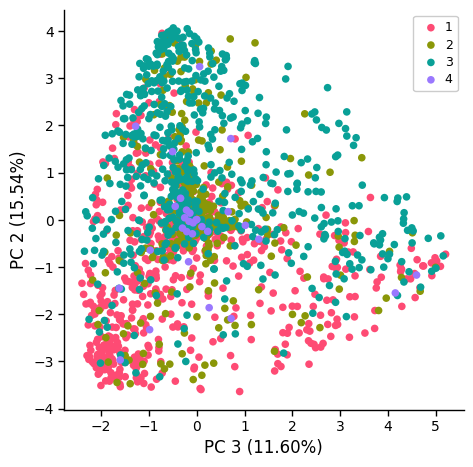

In [160]:
_ = plot.plot_pca(
    P_df,
    pca,
    cohort_s=mice_01_ccp.loc[P_df.index, "cluster"],
    show_ax2=False,
    order=[2,3,4]
)

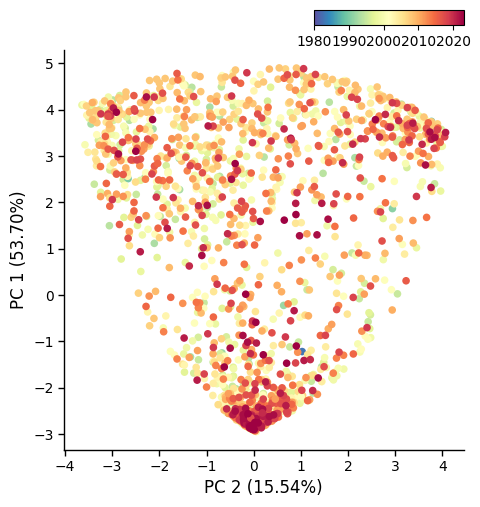

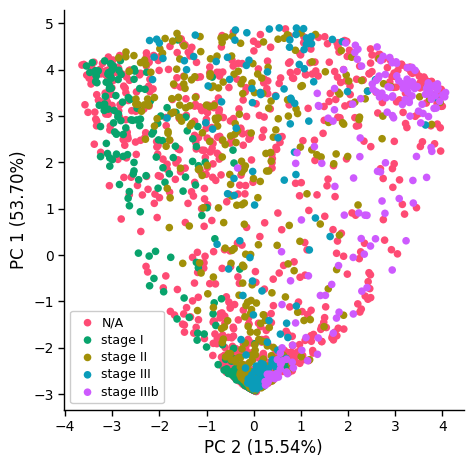

In [156]:
_ = plot.plot_pca(
    P_df,
    pca,
    c=data_df.loc[P_df.index, "Date of diagnosis"].dt.year,
    show_ax2=False,
)

_ = plot.plot_pca(
    P_df,
    pca,
    cohort_s=data_df.loc[P_df.index, "BU (BNP-based) cardiac staging"].fillna("N/A"),
    show_ax2=False
)

In [ ]:
# KNN Imputed
#P_df, pca, pca_vars = utils.get_pcs(Xi_knn.T)
#P_df.join(Xi_knn).corr('spearman').loc[Xi_knn.columns, P_df.columns].sort_values(1)

# _ = plot.plot_pca(
#     P_df,
#     pca,
#     c=data_df.loc[P_df.index, "Date of diagnosis"].dt.year,
#     show_ax2=False
# )

# _ = plot.plot_pca(
#     P_df,
#     pca,
#     cohort_s=data_df.loc[P_df.index, "BU (BNP-based) cardiac staging"].fillna("N/A"),
#     show_ax2=False
# )

In [196]:
def get_ppca(X: pd.DataFrame, normalize:bool=True):
    """Get Probablistic PCA

    Args:
        X (pd.DataFrame): _description_
        normalize (bool, optional): _description_. Defaults to True.

    Returns:
        _type_: _description_
    """
    from ppca import PPCA
    import scipy

    if normalize:
        X = scipy.stats.zscore(X, nan_policy='omit', axis=1)
    
    ppca = PPCA()
    ppca.fit(X.values, d=100, verbose=False)

    P_df = pd.DataFrame(ppca.data, index=X.index, columns=range(ppca.data.shape[1]))
    ppca.explained_variance_ratio_ = ppca.var_exp

    return P_df, ppca

In [197]:
ppca_df, ppca = get_ppca(X)

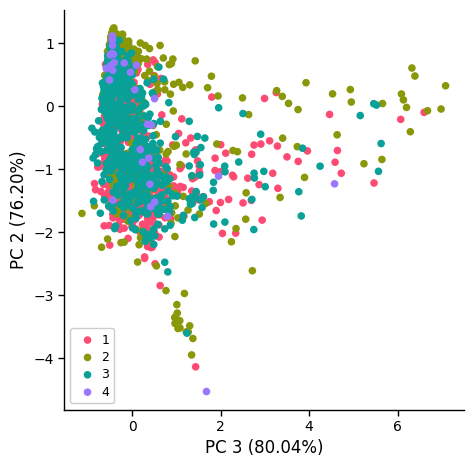

In [202]:
_ = plot.plot_pca(
    ppca_df,
    ppca,
    cohort_s=mice_01_ccp.loc[P_df.index, "cluster"],
    show_ax2=False,
    order=[2,3,4]
)

In [185]:
def plot_pca(X, ppca, x_pc=1, y_pc=2, ax=None):
    """Plot PCA."""
    P_df = pd.DataFrame(
        ppca.data, 
        index=X.index, 
        columns=["PC{}".format(x+1) for x in range(ppca.data.shape[1])]
    )

    if ax is None:
        fig,ax = plt.subplots(figsize=(5,5))

    ax.scatter(P_df['PC{}'.format(x_pc)], P_df['PC{}'.format(y_pc)])

#plot_pca(X, ppca, x_pc=2, y_pc=3)